# **Ethereum Price Prediction using Time2Vec**

### References

### Reseach Papers
https://arxiv.org/pdf/1907.05321.pdf
https://openreview.net/attachment?id=rklklCVYvB&name=original_pdf

### Kaggle codes
https://www.kaggle.com/danofer/time2vec-water-levels

### Github codes
https://github.com/email81227/Time2Vec-TensorFlow2/tree/master/Time2Vec
https://github.com/cerlymarco/keras-hypetune
https://github.com/tensorflow/addons/issues/2508
https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Time2Vec/Time2Vec.ipynb

### Towards Data Science articles
https://towardsdatascience.com/neural-networks-with-sine-basis-function-c5c13fd63513 (paper on sine basis function)
https://towardsdatascience.com/time2vec-for-time-series-features-encoding-a03a4f3f937e

### Implementation of the model

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 12.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=3fab67676760142bb2516952318b88ba56e7890f303392b14d124581c3b92866
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
!pip install keras-hypetune

In [4]:
# Data Manipulation
import numpy as np
import pandas as pd

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
from kerashypetune import KerasGridSearch

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [5]:
df = pdr.get_data_yahoo('ETH-USD', '2016-01-01', '2021-07-19')

[*********************100%***********************]  1 of 1 completed


In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2023 entries, 2016-01-01 to 2021-07-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2023 non-null   float64
 1   High       2023 non-null   float64
 2   Low        2023 non-null   float64
 3   Close      2023 non-null   float64
 4   Adj Close  2023 non-null   float64
 5   Volume     2023 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.6 KB


In [8]:
df = df.reset_index()

Text(0, 0.5, 'Close Price (USD)')

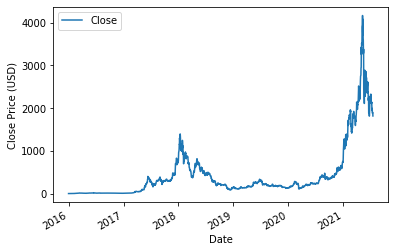

In [9]:
ax = df.plot(x='Date' , y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

### Data Normalization

In [26]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1) # -1 in reshape function is used when you dont know or want to explicitly tell the dimension of that axis

scaled_close = scaler.fit_transform(close_price) # This method performs fit and transform on the input data at a single time and converts the data points

### Define Time2Vec + LSTM model

In [28]:
# The special syntax **kwargs in function definitions in python is used to pass a keyworded, variable-length argument list. 
# We use the name kwargs with the double star. The reason is because the double star allows us to pass through keyword arguments (and any number of them)

In [30]:
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import backend as K # Keras is a model-level library, providing high-level building blocks for developing deep learning models. It does not handle itself low-level operations such as tensor products, convolutions and so on. Instead, it relies on a specialized, well-optimized tensor manipulation library to do so, serving as the “backend engine” of Keras.
from tensorflow.keras.layers import Layer

In [31]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p #if i = 0
        sin_trans = K.sin(K.dot(x, self.W) + self.P) # Frequecy and phase shift of sine function, learnable parameters. if 1 <= i <= k
        
        return K.concatenate([sin_trans, original], -1)

In [32]:
# To create X and Y for you
def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [33]:
def T2V_NN(param, dim):
    
    inp = layers.Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer='adam')
    
    return m

### Prepare data to feed models

In [34]:
SEQ_LEN = 20 # pattern X is the size of Seq_len (e.g. use the first 20 days to predict 21st day)
X, Y = [], []
for sequence in gen_sequence(df, SEQ_LEN, ['Close']):
    X.append(sequence)
    
for sequence in gen_labels(df, SEQ_LEN, ['Close']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

### Train Test Split

In [35]:
train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1416, 20, 1) (1416, 1)
(587, 20, 1) (587, 1)


### Define parameter grid for hyperparameter optimization

In [54]:
param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64,16],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 20,
    'batch_size': [128,512,1024]
}

In [53]:
hypermodel = lambda x: T2V_NN(param=x, dim=SEQ_LEN)

kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_t2v.search(X_train, y_train, validation_split=0.2, shuffle=False)


72 trials detected for ('unit', 't2v_dim', 'lr', 'act', 'epochs', 'batch_size')

***** (1/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 20, 'batch_size': 128})
SCORE: 1709.20581 at epoch 20

***** (2/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 20, 'batch_size': 512})
SCORE: 1567.80334 at epoch 20

***** (3/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 20, 'batch_size': 1024})
SCORE: 6248.21338 at epoch 12

***** (4/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 20, 'batch_size': 128})
SCORE: 1388.80554 at epoch 16

***** (5/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 20, 'batch_size': 512})
SCORE: 1288.88 at epoch 12

***** (6/72) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 20, 'batch_size': 1024})
SCORE: 5517.91699 at epoch 20

***** (7/72) *****
Search({'unit': 64, '

<kerashypetune.KerasGridSearch>

### Application of the parameters coming from the Keras Grid Search with the best score

In [ ]:
# Search({'unit': 32, 't2v_dim': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 20, 'batch_size': 1024})

In [ ]:
base_param = {
    'unit': 32,
    't2v_dim': 64,
    'lr': 1e-2, 
    'act': 'elu', 
    'epochs': 20,
    'batch_size': 1024
}

In [55]:
model = T2V_NN(param=base_param, dim=SEQ_LEN)

In [56]:
model.summary()

Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, 20, 1)]           0         
_________________________________________________________________
t2v_83 (T2V)                 (None, 20, 65)            1384      
_________________________________________________________________
lstm_83 (LSTM)               (None, 32)                12544     
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 33        
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 3s 43ms/step - loss: 133270.2344 - val_loss: 35851.4766
Epoch 2/20
36/36 [==============================] - 1s 37ms/step - loss: 121459.0781 - val_loss: 56835.6758
Epoch 3/20
36/36 [==============================] - 1s 36ms/step - loss: 46750.6836 - val_loss: 4838.3003
Epoch 4/20
36/36 [==============================] - 1s 36ms/step - loss: 106326.4141 - val_loss: 2772.8376
Epoch 5/20
36/36 [==============================] - 1s 37ms/step - loss: 64126.7500 - val_loss: 2400.9026
Epoch 6/20
36/36 [==============================] - 1s 38ms/step - loss: 21719.8984 - val_loss: 2285.7275
Epoch 7/20
36/36 [==============================] - 1s 36ms/step - loss: 9985.7129 - val_loss: 1403.3636
Epoch 8/20
36/36 [==============================] - 1s 37ms/step - loss: 16519.0215 - val_loss: 6533.4663
Epoch 9/20
36/36 [==============================] - 1s 38ms/step - loss: 9380.4043 - val_loss: 2784.5525
Epoch 10/20
36/36 [========================

In [58]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 4ms/step - loss: 102858.4297


102858.4296875

### Graph plot to see the loss variables vs epoch

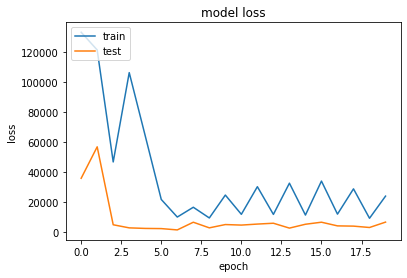

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Graph plot to see the actual vs predicted price

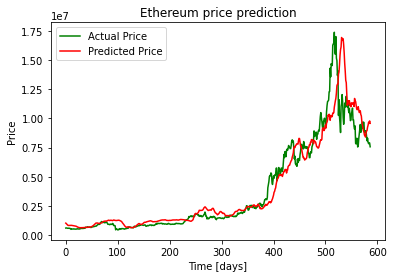

In [60]:
y_hat = model.predict(X_test)

# scale in a way that is easier to visualize in the graph (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
# inverse_transform: Scale back the data to the original representation
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();